<div style="display:fill;
           background-color:#F2E5E5;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/refs/heads/main/Land_Cover_EUROSAT/thumb.jpg">
<H1 style="padding: 20px; color:black; font-weight:600; font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 38px;">Land-Cover Classification with EuroSAT Dataset </H1>
</div>


In [62]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import re
import json
import shap

import PIL
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import imutils
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D, Dropout#, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.optimizers import Adam

from keras.applications import VGG16, VGG19, MobileNetV2 
from keras.applications import ResNet50, ResNet50V2, ResNet152V2, ResNet101V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score, f1_score, precision_score, recall_score

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Data Exploration

In [11]:
IMAGE_DIR = "/kaggle/input/eurosat-rgb/2750"
LABELS = os.listdir(IMAGE_DIR)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


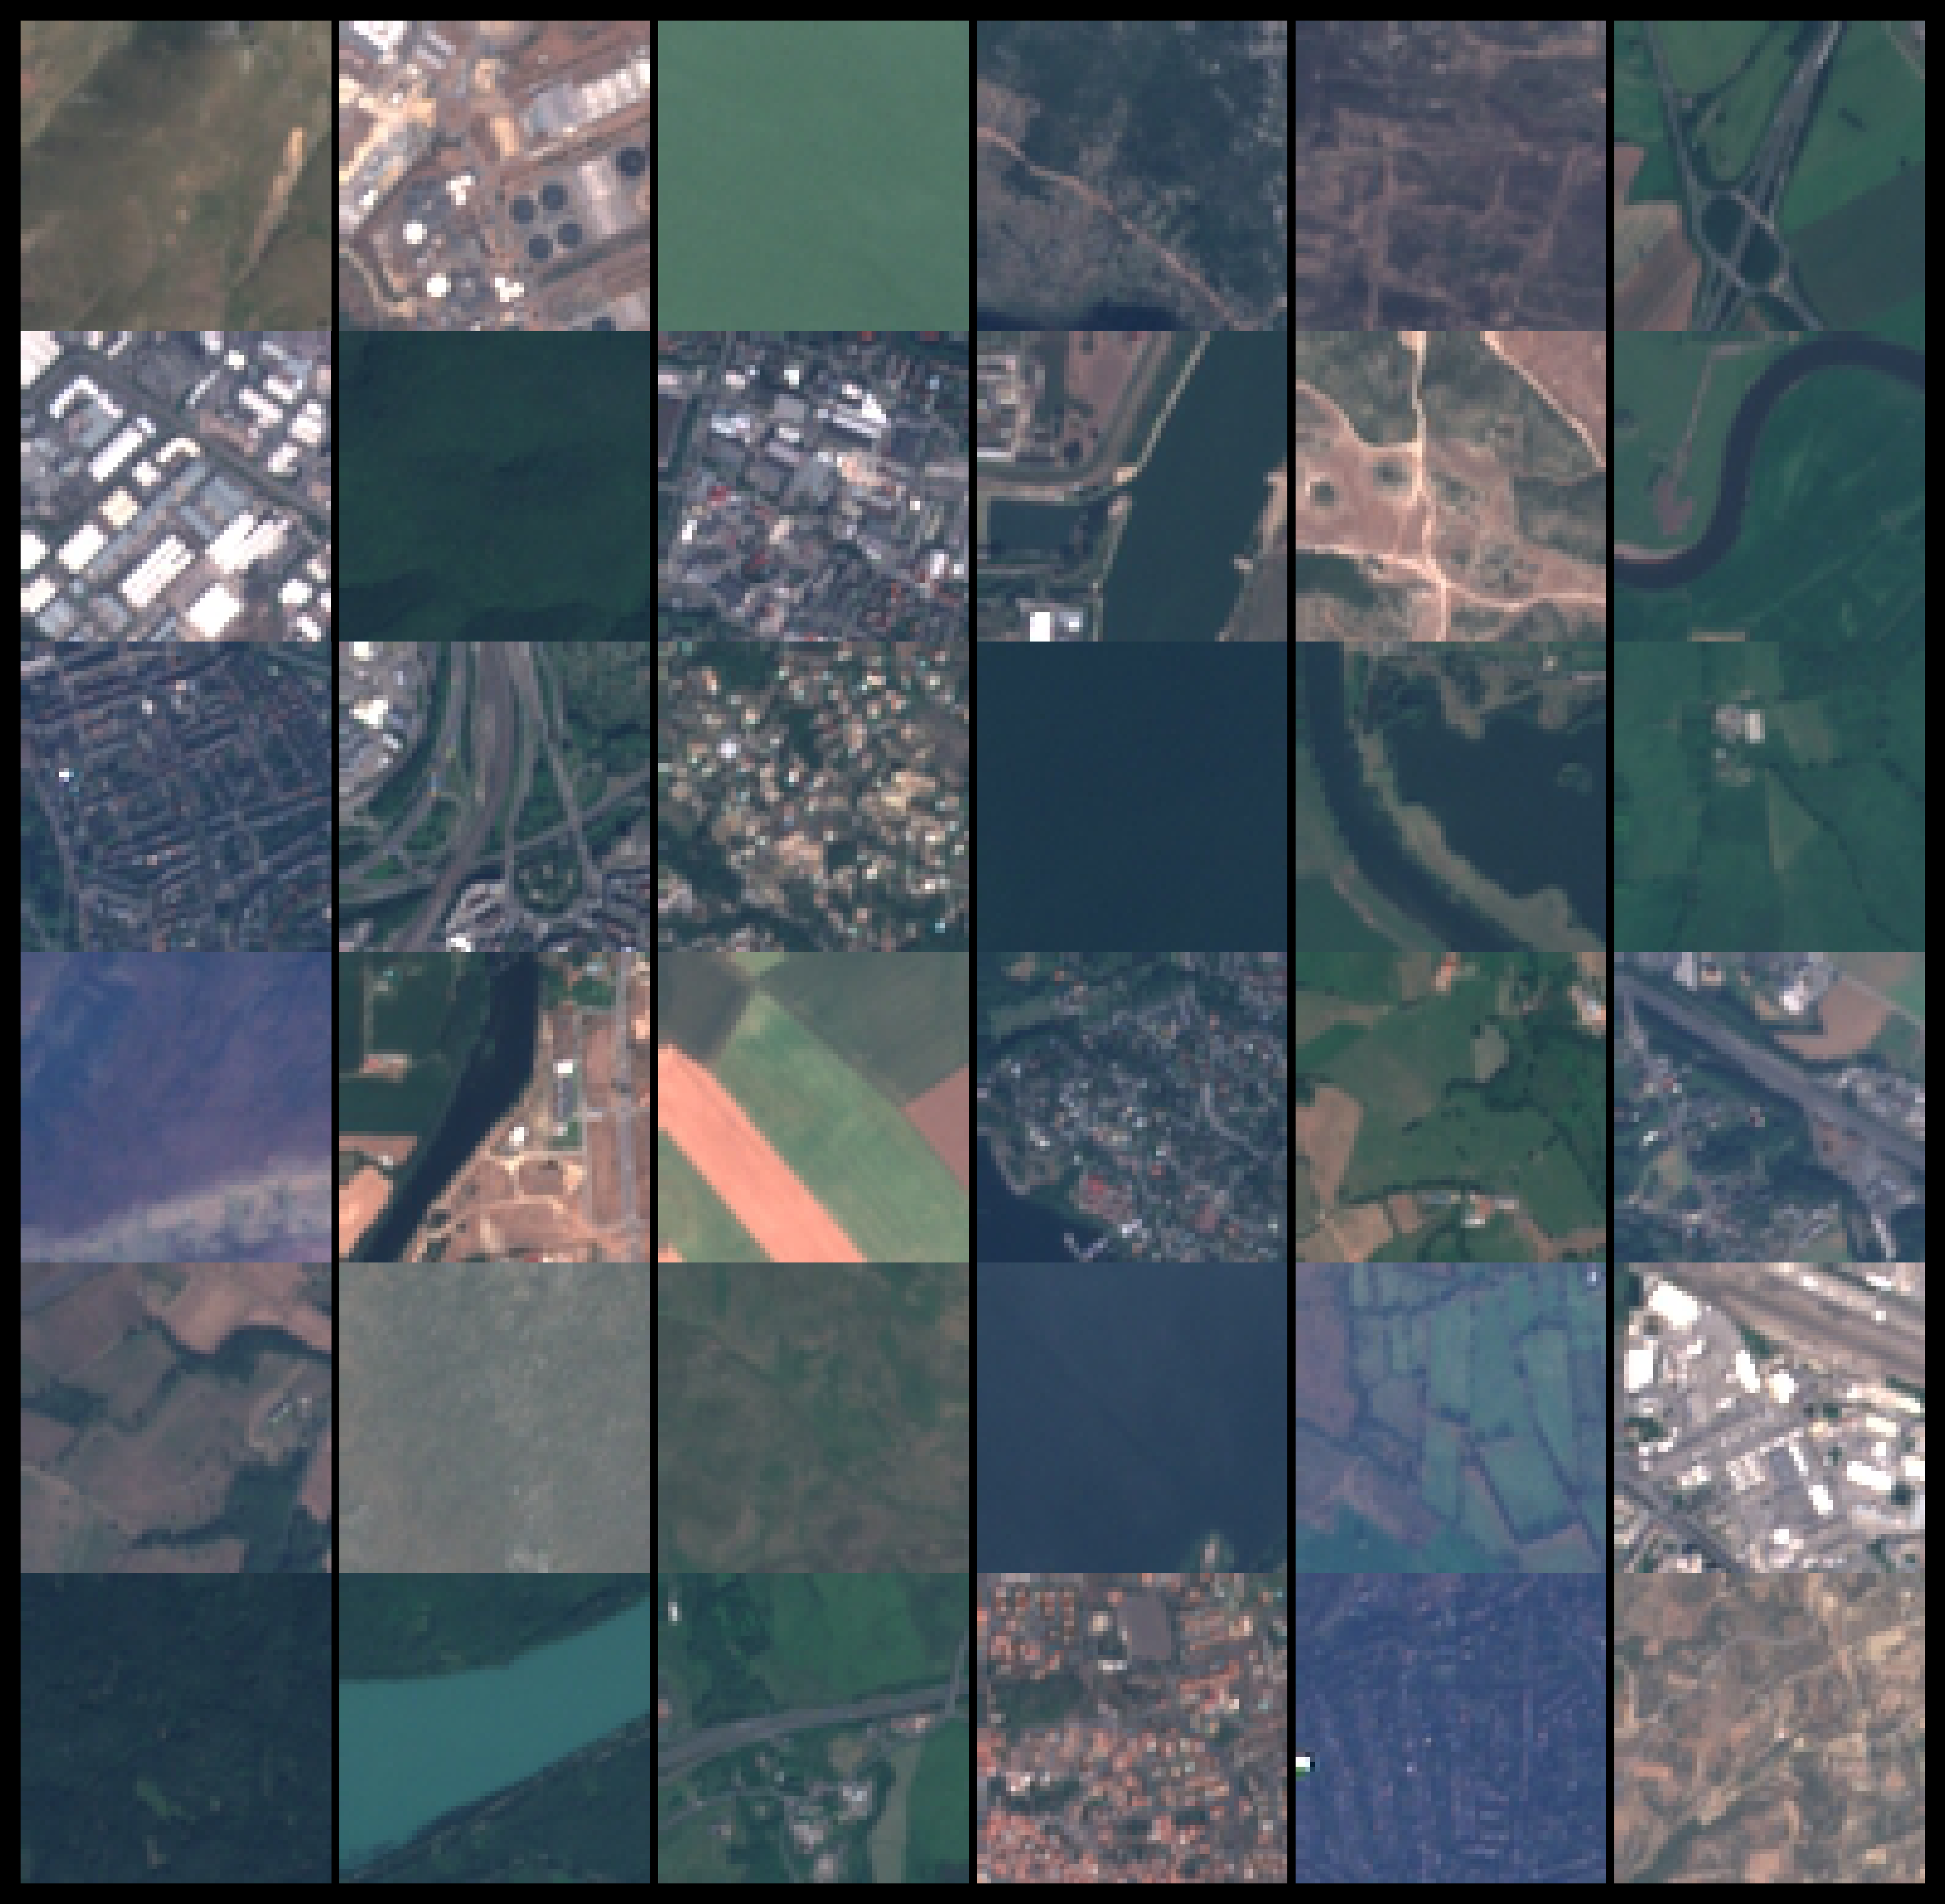

In [12]:
fig, axs = plt.subplots(6, 6,figsize=(12,12),dpi=500)
for i in range(6):
    for j in range(6):
        label = np.random.choice(LABELS)
        number = np.random.randint(1000,2000)
        img_path = IMAGE_DIR+"/"+label+"/"+label+"_"+str(number)+".jpg"
        img = PIL.Image.open(img_path, 'r')
        axs[i, j].imshow(img)
        axs[i, j].axis("off")

for ax in axs.ravel():
    ax.set_axis_off();
    
plt.subplots_adjust(wspace=0, hspace=0);
# plt.tight_layout();
fig.patch.set_facecolor('black')
plt.savefig("image.png");
plt.show();

In [13]:
# def augment_data(file_dir, save_to_dir, n_generated_samples = 2):
#     data_gen = ImageDataGenerator(rotation_range=10, 
#                                   width_shift_range=0.1, 
#                                   height_shift_range=0.1, 
#                                   shear_range=0.1, 
#                                   brightness_range=(0.5, 1.0),
#                                   horizontal_flip=True, 
#                                   vertical_flip=True, 
#                                   fill_mode='nearest'
#                                  )

#     for filename in listdir(file_dir):
#         image = cv2.imread(file_dir + '/' + filename)
#         # reshape the image
#         image = image.reshape((1,)+image.shape)
#         save_prefix = 'aug_' + filename[:-4]
#         i=0
#         for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break

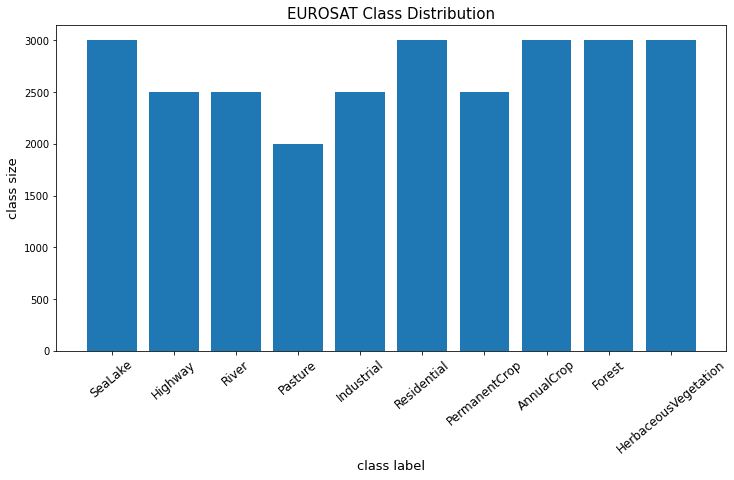

In [14]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(IMAGE_DIR, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

# Data Preprocessing

In [15]:
# SET SEED
np.random.seed(6)
seed = np.random.randint(123)
print(seed)

10


In [16]:
TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 128
NUM_CLASSES = len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'
TEST_SIZE = 0.25

for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

for l in LABELS:
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [17]:
# # map each image path to their class label in 'data'
# data = {}

# for l in LABELS:
#     for img in os.listdir(IMAGE_DIR+'/'+l):
#         data.update({os.path.join(IMAGE_DIR, l, img): l})

# X = pd.Series(list(data.keys()))
# y = pd.get_dummies(pd.Series(data.values()))

# split = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=seed)

# # split the list of image paths
# for train_idx, test_idx in split.split(X, y):
    
#     train_paths = X[train_idx]
#     test_paths = X[test_idx]

#     # define a new path for each image depending on training or testing
#     new_train_paths = [re.sub('\.\.\/input\/2750', '../working/training', i) for i in train_paths]
#     new_test_paths = [re.sub('\.\.\/input\/2750', '../working/testing', i) for i in test_paths]

#     train_path_map = list((zip(train_paths, new_train_paths)))
#     test_path_map = list((zip(test_paths, new_test_paths)))
    
#     # move the files
#     # print("moving training files..")
#     for i in tqdm(train_path_map,desc = "Moving Training Data"):
#         if not os.path.exists(i[1]):
#             if not os.path.exists(re.sub('training', 'testing', i[1])):
#                 shutil.copy(i[0], i[1])
    
#     # print("moving testing files..")
#     for i in tqdm(test_path_map,desc = "Moving Testing Data"):
#         if not os.path.exists(i[1]):
#             if not os.path.exists(re.sub('training', 'testing', i[1])):
#                 shutil.copy(i[0], i[1])

In [18]:
TRAIN_DIR = "/kaggle/input/lulc-eurosat/training"
TEST_DIR  = "/kaggle/input/lulc-eurosat/testing"

# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.0),
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest'
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=seed
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=seed
)

pred_generator = test_gen.flow_from_directory(  #no batches
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=seed
)

Found 20250 images belonging to 10 classes.
Found 6750 images belonging to 10 classes.
Found 6750 images belonging to 10 classes.


In [19]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [20]:
np.save('class_indices', train_generator.class_indices)

# Building Deep Learning Models

1. Custom CNN
2. MobileNetV2
3. ResNet101V2


In [21]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

In [22]:
def plot_history(history):
       
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title("Acc vs Val Acc")
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title("Loss vs Val Loss")
    
    plt.show();

In [23]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=4,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

# 0. ResNet50 SHAP

In [26]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [28]:
def build_resnet50(input_shape ,fine_tune=None):
    conv_base = ResNet50(include_top=False,
                             weights='imagenet', 
                             input_shape=input_shape)
    base_model = conv_base.output
    base_model = Flatten()(base_model)
    base_model = Dense(1000)(base_model)
    base_model = Dropout(0.2)(base_model)
    output_layer = Dense(len(LABELS),activation="softmax")(base_model) #o/p layer
    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]: layer.trainable = True
    else:
        for layer in conv_base.layers: layer.trainable = False
    
    return model

resnet = build_resnet50(INPUT_SHAPE,20)

train_generator.reset()
test_generator.reset()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=5,
                                      callbacks=[early_stop, reduce_lr],
                                      validation_data=test_generator, validation_steps=N_VAL_STEPS)

Epoch 1/1
158/158 [==============================] - 110s 694ms/step - loss: 1.5422 - accuracy: 0.6882 - val_loss: 0.0131 - val_accuracy: 0.1002


In [69]:
# # python function to get model output; replace this function with your own model function.
# def f(x):
#     tmp = x.copy()
#     return model(tmp)


# # define a masker that is used to mask out partitions of the input image.
# masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# # create an explainer with model and image masker
# explainer = shap.Explainer(f, masker, output_names=class_names)

# # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
# shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip)

## 1. Custom CNN Model

In [70]:
def build_model(input_shape):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(16,5,activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(32,5,activation="relu"))
    model.add(Conv2D(32,5,activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,7,activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(len(LABELS),activation="softmax"))
    return model

custom_model = build_model(INPUT_SHAPE)

In [122]:
train_generator.reset()
test_generator.reset()

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=50,
                                                  callbacks=[early_stop, reduce_lr],
                                                  validation_data=test_generator, validation_steps=N_VAL_STEPS)

Train for 158 steps, validate for 52 steps
Epoch 1/50
158/158 [==============================] - 86s 547ms/step - loss: 1.4907 - accuracy: 0.4450 - val_loss: 1.3527 - val_accuracy: 0.5397
Epoch 2/50
158/158 [==============================] - 51s 325ms/step - loss: 1.0892 - accuracy: 0.6052 - val_loss: 1.0576 - val_accuracy: 0.6300
Epoch 3/50
158/158 [==============================] - 51s 326ms/step - loss: 1.0430 - accuracy: 0.6190 - val_loss: 1.0206 - val_accuracy: 0.6109
Epoch 4/50
158/158 [==============================] - 51s 324ms/step - loss: 1.0417 - accuracy: 0.6158 - val_loss: 1.2987 - val_accuracy: 0.4985
Epoch 5/50
158/158 [==============================] - 51s 321ms/step - loss: 1.0881 - accuracy: 0.5952 - val_loss: 1.0317 - val_accuracy: 0.6056
Epoch 6/50
158/158 [==============================] - 51s 321ms/step - loss: 0.9673 - accuracy: 0.6425 - val_loss: 0.9712 - val_accuracy: 0.6438
Epoch 7/50
158/158 [==============================] - 50s 319ms/step - loss: 0.9305 - a

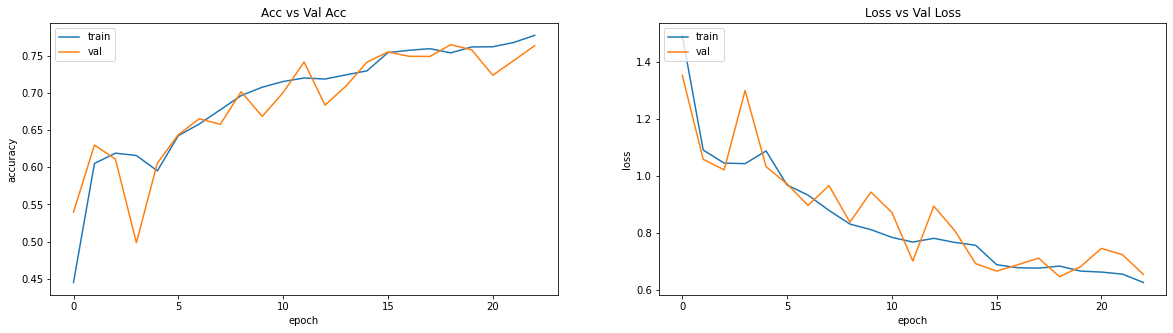

In [123]:
plot_history(custom_model_history)

# LIME

In [124]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [125]:
import cv2
im = cv2.imread("/kaggle/input/lulc-eurosat/training/AnnualCrop/AnnualCrop_10.jpg")

explanation = explainer.explain_instance(im.astype('double'), resnet.predict, top_labels=5, hide_color=0, num_samples=1000)


100% |########################################################################|


In [126]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels


In [127]:
from PIL import Image
image = Image.open("/kaggle/input/lulc-eurosat/training/AnnualCrop/AnnualCrop_10.jpg")

explanation = explainer.explain_instance(np.asarray(image).astype('double'), resnet.predict, top_labels=5, hide_color=0, num_samples=1000)


100% |########################################################################|


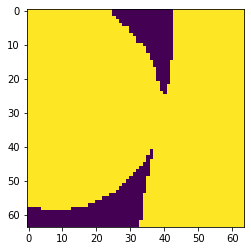

In [128]:
plt.imshow(mask)

In [129]:
masked_image = np.ma.masked_array(np.asarray(image), mask=mask)

MaskError: Mask and data not compatible: data size is 12288, mask size is 4096.

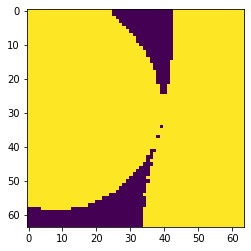

In [134]:
plt.imshow(mask)

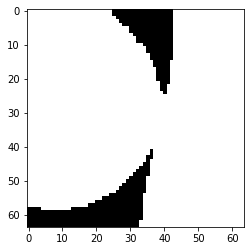

In [131]:
plt.imshow(temp)

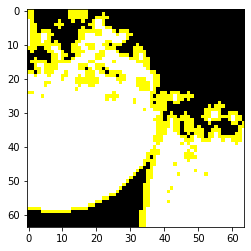

In [138]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)
plt.imshow(image)
plt.imshow(mark_boundaries(temp, mask))


In [140]:
mask

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

# 2. Transfer Learning MobileNetV2 

In [133]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [ ]:
def build_mobilenet(input_shape, fine_tune=None):
    conv_base = MobileNetV2(include_top=False,
                             weights='imagenet', 
                             input_shape=input_shape)
    base_model = conv_base.output
    base_model = Flatten()(base_model)
    base_model = Dense(1000)(base_model)
    base_model = Dropout(0.2)(base_model)
    output_layer = Dense(len(LABELS),activation="softmax")(base_model) #o/p layer
    model = Model(inputs=conv_base.input, outputs=output_layer)
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]: layer.trainable = True
    else:
        for layer in conv_base.layers: layer.trainable = False
    return model

mobilenet = build_mobilenet(INPUT_SHAPE,20)

train_generator.reset()
test_generator.reset()

mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_history = mobilenet.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=50,
                                            callbacks=[early_stop, reduce_lr],
                                            validation_data=test_generator, validation_steps=N_VAL_STEPS)

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/50


In [ ]:
plot_history(mobilenet_history)

# 3. Transfer Learning ResNet101V2 

In [ ]:
def build_resnet101(input_shape ,fine_tune=None):
    conv_base = ResNet101V2(include_top=False,
                             weights='imagenet', 
                             input_shape=input_shape)
    base_model = conv_base.output
    base_model = Flatten()(base_model)
    base_model = Dense(1000)(base_model)
    base_model = Dropout(0.2)(base_model)
    output_layer = Dense(len(LABELS),activation="softmax")(base_model) #o/p layer
    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]: layer.trainable = True
    else:
        for layer in conv_base.layers: layer.trainable = False
    
    return model

resnet = build_resnet101(INPUT_SHAPE,20)

train_generator.reset()
test_generator.reset()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet.fit_generator(train_generator, steps_per_epoch=N_STEPS, epochs=50,
                                      callbacks=[early_stop, reduce_lr],
                                      validation_data=test_generator, validation_steps=N_VAL_STEPS)

In [ ]:
plot_history(resnet_history)

# 4. ResNet50

# Evaluation

In [ ]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    accuracy = accuracy_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds,average='macro')
    precision = precision_score(y_true, y_preds,average='macro')
    recall = recall_score(y_true, y_preds,average='macro')
    
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")    
    print(f"Precision Score: {precision}")
    print(f"Recall Score: {recall}")  
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 12))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

## Evaluating Custom CNN Model

In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
pred_generator.reset()

predictions = custom_model.predict_generator(pred_generator, steps=len(pred_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = pred_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f');
plt.title("Conf Matrix for Custom CNN Model");

In [ ]:
plot_predictions(true_classes, predictions, pred_generator, class_indices)

## Evaluating MobileNetV2 Model

In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
pred_generator.reset()

predictions = mobilenet.predict_generator(pred_generator, steps=len(pred_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = pred_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f');
plt.title("Conf Matrix for MobileNetV2");

In [ ]:
plot_predictions(true_classes, predictions, pred_generator, class_indices)
plt.savefig("sample_output.png")

## Evaluating ResNet101V2 Model

In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
pred_generator.reset()

predictions = resnet.predict_generator(pred_generator, steps=len(pred_generator.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = pred_generator.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat,annot=True,fmt='.0f');
plt.title("Conf Matrix for ResNet101V2 Model");

In [ ]:
plot_predictions(true_classes, predictions, pred_generator, class_indices)
plt.savefig("sample_output.png")